In [1]:
__author__ = 'Knut Olsen <kolsen@noao.edu>' # single string; emails in <>
__version__ = '20210330' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['stripe82','nsc_dr1']  # datasets used in this notebook; for available datasets, see cell "Available datasets in Data Lab" further below
__keywords__ = ['image cutout','SIA','tutorial'], # keywords relevant to this notebook, e.g. ['science case','dwarf galaxies'] Use only keywords from the master list: https://github.com/noaodatalab/notebooks-latest/blob/master/keywords.txt

# How to use the Simple Image Access (SIA) Service to make image cutouts

*Knut Olsen & NOAO Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [What is the Simple Image Access service?](#chapter1)
* [Example usage](#chapter2)
* [Making the process easier with functions](#chapter3)

<a class="anchor" id="goals"></a>
# Goals
Show how to use the Simple Image Access (SIA) Service API to make image cutouts.

# Summary
In this notebook, we describe and demonstrate the SIA Service API and use it to make an example set of image cutouts.  We list all of the available image collections available through SIA services, and then select one to retrieve an image cutout at a specific RA, Dec on the sky.  We define a function to identify the deepest image available at a specific band and position, retrieve g, r, and i band image cutouts at that position, and make a three-band color image from the cutouts.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, https://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noao.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# std lib
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

# 3rd party
import numpy as np
from numpy.core.defchararray import startswith
import pylab as plt
import matplotlib
%matplotlib inline

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Data Lab
from dl import queryClient as qc, storeClient as sc, authClient as ac

<a class="anchor" id="auth"></a>
# Authentication
Some functionality in this notebook (saving results to your VOSpace) requires that you are logged in through the authClient. If needed, please un-comment the line starting with `#token = ac.login` below, and run the cell, following the instructions to enter your Data Lab username and password. You only need to do this once (unless you log out through authClient), as the authentication token is stored on the server and automatically detected.

In [3]:
# As an anonymous user, you can issue queries to the database or retrieve image cutouts, but
# not store your results in virtual storage or myDB

# Get token for an authenticated user if you wish to use virtual storage or myDB
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))
ac.whoAmI()

'robertdemo'

<a class="anchor" id="chapter1"></a>
# What is the Simple Image Access service?
The SIA service is a tool to identify the set of images in an image collection that overlap the position at which an image cutout is desired.  It returns a table of potential images containing information (metadata) typically found in the image headers (filter, exposure time, time of observation, etc.) as well as a URL pointing to the image cutout itself.  Getting image cutouts is thus a three-step process: 1) choose an image collection, 2) call the SIA service for that collection to retrieve information about images that overlap a position of interest, and 3) retrieve the image cutouts by accessing the URLs for the selected images in the table of information.

Choosing a specific image collection is done by selecting the URL that points to that collection.  There are lots of available collections, including images from the Dark Energy Survey, Legacy Survey, and the entire NOAO Science Archive.

For more background on the SIA protocol, see the <a href="http://www.ivoa.net/documents/SIA/">IVOA document</a> that describes it.

In [4]:
#List of Simple Image Access (SIA) service endpoints for different image collections

# The default endpoint points to the entire public NOAO Science Archive
DEF_ACCESS_URL = "https://datalab.noao.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

# The NOAO Science Archive is the default endpoint.  It contains all public data in the archive, including
# raw and processed images, data quality masks, etc.
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/nsa"
svc_nsa = sia.SIAService(DEF_ACCESS_URL)

# The subset of images from the NOAO Science Archive that overlap with SDSS Stripe 82
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_nsa"
svc_stripe82 = sia.SIAService(DEF_ACCESS_URL)
# Other targeted image subsets that overlap with SDSS Stripe 82
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_calibrated"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_coadd"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_des_dr1"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_ls_dr3"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_ls_dr4"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_ls_dr5"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_ls_dr6"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_ls_dr7"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_raw"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_smash_dr1"
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/stripe82_splus_dr1"

# The subset of instrument calibrated images from the NOAO Science Archive
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/calibrated_all"
svc_cal = sia.SIAService(DEF_ACCESS_URL)
# Other collections of instrument calibrated images for specific surveys
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/calibrated_des_y1" # DES Year 1 calibrated images
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/calibrated_des_y2" # DES Year 2 calibrated images
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/calibrated_des_y3" # DES Year 3 calibrated images
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/calibrated_des_y4" # DES Year 4 calibrated images
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/calibrated_smash_dr1" # SMASH DR1 calibrated images

# The subset of stacked calibrated images from the NOAO Science Archive
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_all"
svc_coadd = sia.SIAService(DEF_ACCESS_URL)
# Other collections of stacked images for specific surveys
# To use these, call svc = sia.SIAService(DEF_ACCESS_URL)
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_decaps_dr1" # DECaPS DR1 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_des_dr1" # DES DR1 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_ls_dr3" # Legacy Survey DR3 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_ls_dr4" # Legacy Survey DR4 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_ls_dr5" # Legacy Survey DR5 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_ls_dr6" # Legacy Survey DR6 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_ls_dr7" # Legacy Survey DR7 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_smash_dr1" # SMASH DR1 stacks
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/coadd_splus_dr1" # S-PLUS DR1 stacks

# The subset of raw uncalibrated images from the NOAO Science Archive
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/raw_all"
svc_raw = sia.SIAService(DEF_ACCESS_URL)

# The Dark Energy Survey DR1 image release contains images from the first three years of DES
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_dr1"
svc_des_dr1 = sia.SIAService(DEF_ACCESS_URL)

# The Dark Energy Survey SV image release contains images from the DES SV period
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_sva1"
svc_des_sva1 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the first year of DES
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_y1"
svc_des_y1 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the second year of DES
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_y2"
svc_des_y2 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the third year of DES
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_y3"
svc_des_y3 = sia.SIAService(DEF_ACCESS_URL)

# The subset of Dark Energy Survey DR1 images obtained in the fourth year of DES
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_y4"
svc_des_y4 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from Legacy Survey DR3
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/ls_dr3"
svc_ls_dr3 = sia.SIAService(DEF_ACCESS_URL)

# Mosaic-3 and Bok images from Legacy Survey DR4
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/ls_dr4"
svc_ls_dr4 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from Legacy Survey DR5
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/ls_dr5"
svc_ls_dr5 = sia.SIAService(DEF_ACCESS_URL)

# Mosaic-3 and Bok images from Legacy Survey DR6
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/ls_dr6"
svc_ls_dr6 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from Legacy Survey DR7
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/ls_dr7"
svc_ls_dr7 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from the DECam Plane Survey DR1
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/decaps_dr1"
svc_decaps_dr1 = sia.SIAService(DEF_ACCESS_URL)

# DECam images from the SMASH Survey DR1 release
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/smash_dr1"
svc_smash_dr1 = sia.SIAService(DEF_ACCESS_URL)

# T80S telescope images from the S-PLUS DR1 release
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/splus_dr1"
svc_splus_dr1 = sia.SIAService(DEF_ACCESS_URL)


<a class="anchor" id="chapter2"></a>
# Example usage
We will pick a location in Stripe 82 and use the Stripe 82-specific SIA service to retrieve an image cutout 6x6 arcmin in size.  We use the search method of the SIA service object to perform the search, and return the result as an astropy Table object.  The search method takes as arguments a tuple containing (ra,dec) and a second tuple with the size of the cutout in each direction.  The search works in RA and Dec in degrees, and does not account for the convergence of lines of RA toward the poles, so we add a cos(dec) term in the RA size term.

In [5]:
ra = 335.0 # in degrees
dec = 0.0 # in degrees
fov = 0.1 # in degrees

imgTable = svc_stripe82.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

The result is a table of metadata for images that overlap the search position:

In [6]:
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20161005t022546,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161005_022804_opd_g_v1.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,3369,,,2,0,0,2,[8 1993],,,[0.26984],,ct4m20161005t022546,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161005_022804_opd_g_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161005_022804_opd_g_v1.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.877,-0.0732692,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.15999997,2012B-0001,29.7849998,dqmask,0.746999979,0,,90,,Resampled,2016-10-05T02:25:46.369593,557666.10123113,0
ct4m20161005t022546,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161005_022804_opi_g_v1.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,285297,,,2,0,0,2,[24 1993],,,[0.26984],,ct4m20161005t022546,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161005_022804_opi_g_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161005_022804_opi_g_v1.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.877,-0.0732692,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.15999997,2012B-0001,29.7849998,image,0.746999979,0,,90,,Resampled,2016-10-05T02:25:46.369593,557666.10123113,0
ct4m20161005t022546,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161005_022804_opw_g_v2.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,283907,,,2,0,0,2,[32 1993],,,[0.26984],,ct4m20161005t022546,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161005_022804_opw_g_v2.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161005_022804_opw_g_v2.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.877,-0.0732692,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.15999997,2012B-0001,29.7849998,wtmap,0.746999979,0,,90,,Resampled,2016-10-05T02:25:46.369593,557666.10123113,0
ct4m20161105t002424,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161105_002645_opw_z_v1.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,285716,,,2,0,0,2,[32 1994],,,[0.26984],,ct4m20161105t002424,,2012B-0001,archival,,,DECam,z,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_161105_002645_opw_z_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_161105_002645_opw_z_v1.fits.fz&extn=31&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.874,-0.0726317,--,,,--,8500.0,10020.0,--,--,--,--,--,--,,,,DES survey hex -251-4 tiling 7,1.15999997,2012B-0001,29.8519993,wtmap,0,0,,90,,Resampled,2016-11-05T00:24:24.501608,557697.01695025,0
ct4m20130617t102449,"https://datalab.noao.edu/svc/cutout?col=&siaRef=dec085741.fits.fz&e

The column `access_url` contains the link to retrieve the image cutout.  We can filter the table on any of the columns to narrow down the list to just the cutouts we want.  Here we'll select stacked images (`proctype=Stack` and `prodtype=image`) observed in the g filter (`obs_bandpass` starts with the the letter 'g'):

In [7]:
sel = (imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'g'))

We'll pick a row from the filtered table and retrieve the image.

In [8]:
row = imgTable[sel]
row

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20130905t015144,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_130905_015144_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,755777,,,3,0,0,2,[24 14041],,,[0.26996],,ct4m20130905t015144,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_130905_015144_osi_g_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_130905_015144_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.51,0.206537,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -251+16 tiling 3,1.38999999,2012B-0001,29.7730007,image,0,6.2807498,,450,,Stack,2013-09-05T01:51:44.997190,556540.07760413,0
ct4m20150718t072406,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_150718_072640_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,378061,,,3,0,0,2,[24 8874],,,[0.26996],,ct4m20150718t072406,,2015A-0619,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_150718_072640_osi_g_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_150718_072640_osi_g_v1.fits.fz&extn=5&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,334.966,0.110729,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,lba334,1.15999997,2015A-0619,29.8670006,image,0,5.5310998,,4500,,Stack,2015-07-18T07:24:06.639994,557221.30841018,0
,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_140512_085654_osi_g_v1.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,358810,,,3,0,0,2,[24 9025],,,[0.26995],,,,2014A-0429,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_140512_085654_osi_g_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_140512_085654_osi_g_v1.fits.fz&extn=4&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,335.017,0.319923,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,md09,1.54999995,2014A-0429,28.1956005,image,0,4.76612997,,540,,Stack,2014-05-12T08:55:04.244386,556789.3715769,0.127379999
ct4m20130905t015351,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_130905_015351_osi_g_v1.fits.fz&extn=9&POS=335.0,0.0&SIZE=0.1,0.1",image/fits,623148,,,3,0,0,2,[32 11969],,,[0.26974],,ct4m20130905t015351,,2012B-0001,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_stripe82.nsa:ivo://datalab.noao//c4d_130905_015351_osi_g_v1.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=&siaRef=c4d_130905_015351_osi_g_v1.fits.fz&extn=9&POS=335.0,0.0&SIZE=0.1,0.1&preview=true",,,335.11,0.322903,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES survey hex -235+6 tiling 3,1.38999999,2012B-0001,29.8129997,image,0,6.15154982,,270,,Stack,2013-09-05T01:53:51.911652,556540.07907305,0


In [9]:
row = imgTable[sel][0]
url = row['access_url'] # get the download URL
filename = download_file(url,cache=True,show_progress=False,timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
hdr = hdu.header
wcs = WCS(hdr)

Then we'll display the image.  Note that the image might not be square for a variety of reasons, such as that the image cutout ran into a chip edge along one axis.

45.37442 14453.205 (1335, 752)


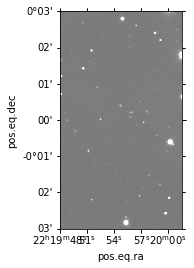

In [10]:
print(image.min(),image.max(),image.shape)
ax = plt.subplot(projection=wcs)
ax.imshow(image,cmap='gray',vmin=image.min(),vmax=image.min()+(image.max()-image.min())/100.)

### Catalog overlay
We can also query the database for catalog objects and overlay them easily on the image cutout.  In this example, we query around the central position for objects in the NOAO Source Catalog DR1 object table:

In [11]:
sql = '''SELECT ra, dec, gmag 
            FROM nsc_dr1.object 
            WHERE Q3C_RADIAL_QUERY(ra,dec,{0},{1},{2})
            AND gerr < 0.1 AND gmag < 22
'''.format(ra, dec, fov/2)
df = qc.query(sql=sql, fmt='pandas')

Here we'll use the object *g*-band magnitudes to control the sizes of the markers.

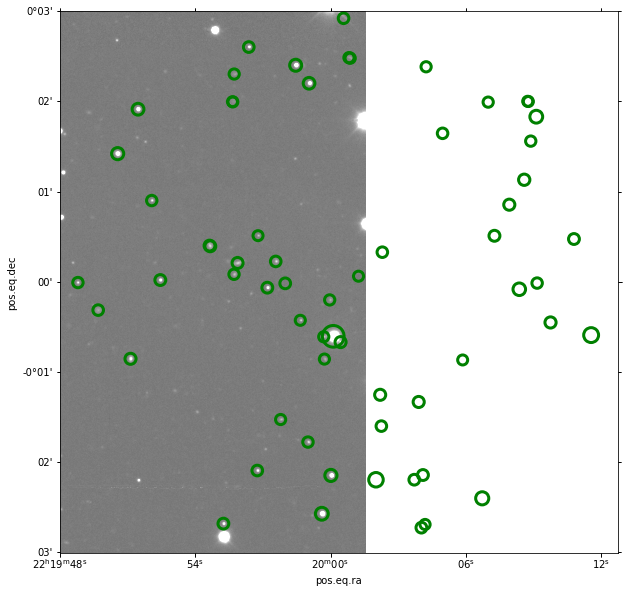

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image, cmap='gray', vmin=image.min(), vmax=image.min()+(image.max()-image.min())/100.)
ax.scatter(df['ra'], df['dec'], transform=ax.get_transform('icrs'), s=1000./(df['gmag']-12), 
           edgecolor='green', facecolor='none', linewidths=3)

## Save image to VOSpace
If you're not intending to display or work with the image in the notebook, but instead want to save the image as a file, the storeClient can copy the cutout URL directly to VOSpace.

First we'll check that we're logged in:

In [13]:
ac.whoAmI() # if result is 'anonymous', you'll need to login with ac.login()

'robertdemo'

Then save the contents of the image cutout URL to VOSpace:

In [14]:
sc.load('cutout.fits',url)

'OK'

In [15]:
print(sc.ls('cutout.fits',format='long'))

-rw-rw-r-x  robertdemo  4037760  06 Dec 2019 11:50  cutout.fits



<a class="anchor" id="chapter3"></a>
# Making the process easier with functions
The example workflow above lends itself to writing s short function to access the SIA service, filter the metadata table to narrow down the search result, and retrieve the cutout.  Here we write a function to get the deepest stacked image for a given image collection and band, and another function to plot the images.

In [16]:
# A little function to download the deepest stacked images
#   adapted from R. Nikutta
def download_deepest_image(ra,dec,svc=sia.SIAService('https://datalab.noao.edu/sia'),fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    
    sel0 = startswith(imgTable['obs_bandpass'].astype(str),band)
    print("The full image list contains", len(imgTable[sel0]), "entries with bandpass="+band)

    sel = sel0 & ((imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image')) # basic selection
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print ('downloading deepest ' + band + ' image...')
        image = fits.getdata(download_file(url,cache=True,show_progress=False,timeout=120))

    else:
        print ('No image available.')
        image=None
        
    return image

In [17]:
# Multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            vmin = np.median(img)-2*np.std(img)
            vmax = np.median(img)+2*np.std(img)
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax)
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

We run the function to get cutouts from deep stack in g, r, and i bands.

In [18]:
band = 'g'
gimage = download_deepest_image(ra, dec, svc=svc, fov=0.1, band=band) # FOV in deg
band = 'r'
rimage = download_deepest_image(ra, dec, svc=svc, fov=0.1, band=band) # FOV in deg
band = 'i'
iimage = download_deepest_image(ra, dec, svc=svc, fov=0.1, band=band) # FOV in deg
images=[gimage,rimage,iimage]

The full image list contains 533 entries with bandpass=g
downloading deepest g image...
The full image list contains 523 entries with bandpass=r
downloading deepest r image...
The full image list contains 350 entries with bandpass=i
downloading deepest i image...


Now we plot the image per band and make a 3-color image from the output.

118.10046 19471.238
360.86533 38469.46
981.00226 35315.805


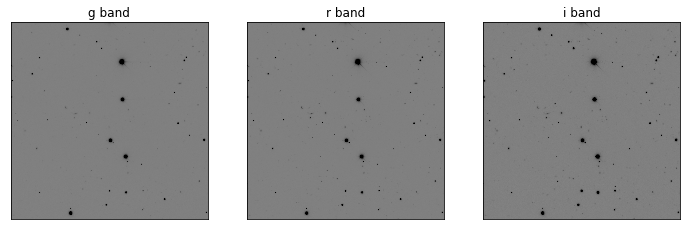

In [19]:
gimage2 = gimage-np.median(gimage)
rimage2 = rimage-np.median(rimage)
iimage2 = iimage-np.median(iimage)
img = make_lupton_rgb(iimage2, rimage2, gimage2, Q=10, stretch=30)
plot_images(images)

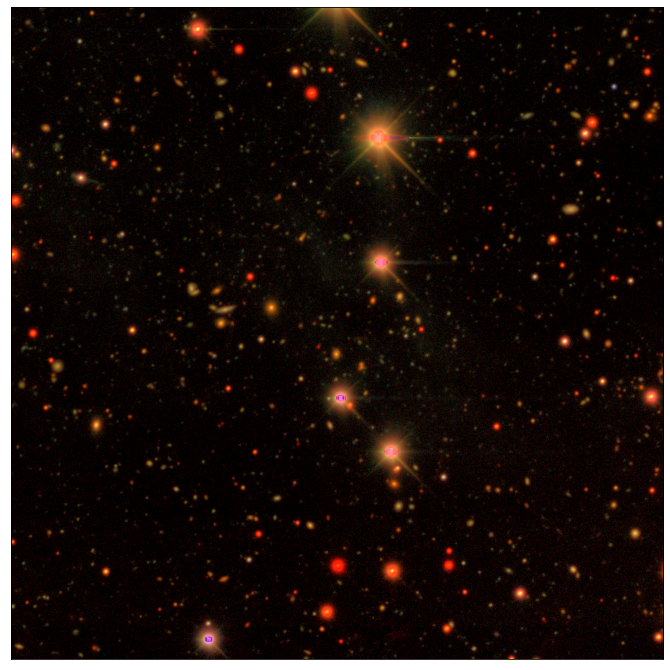

In [20]:
fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(1,1,1)

ax.imshow(img,origin='lower')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)